## 重点
1. 通过代码练习，加深对机器学习，深度学习的理解。明确损失函数，模型部分，熟悉模型的前向过程和反向过程
2. 通过网络部分编码，加深对矩阵运算，矩阵维度变化等基础概念的理解
3. 推演反向传播过程，结合课件，加深对参数更新部分的理解
4. 熟悉matplotlib，sklearn，numpy等基础包的基础用法，tips: 善用dir，help等辅助手段

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

def load_mnist_sklearn():
    """使用sklearn加载MNIST数据集"""
    print("正在从sklearn加载MNIST数据集...")
    # 加载MNIST数据集
    mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='liac-arff')
    
    # 提取数据和标签
    X, y = mnist['data'], mnist['target']
    y = y.astype(np.uint8)
    
    # 划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=10000, random_state=42, stratify=y
    )
    
    # 转置数据以适应我们的网络格式 (features, samples)
    X_train = X_train.T / 255.0
    X_test = X_test.T / 255.0
    
    # one-hot编码
    encoder = OneHotEncoder(sparse_output=False)
    y_train_onehot = encoder.fit_transform(y_train.reshape(-1, 1)).T
    y_test_onehot = encoder.transform(y_test.reshape(-1, 1)).T
    
    print(f"训练集形状: {X_train.shape}")
    print(f"测试集形状: {X_test.shape}")
    print(f"标签类别: {np.unique(y_train)}")
    
    return X_train, y_train_onehot, X_test, y_test_onehot, y_train, y_test

def display_data_samples(X, y, title, num_samples=15):
    """
    展示数据样本
    
    参数:
    X: 图像数据 (samples, features)
    y: 标签
    title: 图表标题
    num_samples: 要展示的样本数量
    """
    # 确保X是(samples, features)格式
    if X.shape[0] != len(y):
        X = X.T  # 转置为(samples, features)
    
    # 随机选择样本
    indices = np.random.choice(len(y), num_samples, replace=False)
    
    plt.figure(figsize=(12, 6))
    plt.suptitle(title, fontsize=16)
    
    # 计算网格布局
    cols = 5
    rows = (num_samples + cols - 1) // cols
    
    for i, idx in enumerate(indices):
        plt.subplot(rows, cols, i + 1)
        
        # 重塑为28x28图像
        image = X[idx].reshape(28, 28)
        label = y[idx]
        
        plt.imshow(image, cmap='gray')
        plt.title(f'Label: {label}', fontsize=10)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # 打印数据统计信息
    print(f"\n{title}统计信息:")
    print(f"数据形状: {X.shape}")
    print(f"像素值范围: [{X.min():.3f}, {X.max():.3f}]")
    print(f"标签分布:")
    unique, counts = np.unique(y, return_counts=True)
    for label, count in zip(unique, counts):
        print(f"  标签 {label}: {count} 个样本 ({count/len(y)*100:.1f}%)")

def display_data_distribution(y_train, y_test):
    """展示训练集和测试集的标签分布"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # 训练集分布
    train_unique, train_counts = np.unique(y_train, return_counts=True)
    ax1.bar(train_unique, train_counts, color='skyblue', alpha=0.7)
    ax1.set_title('训练集标签分布')
    ax1.set_xlabel('数字')
    ax1.set_ylabel('样本数量')
    
    # 测试集分布
    test_unique, test_counts = np.unique(y_test, return_counts=True)
    ax2.bar(test_unique, test_counts, color='lightcoral', alpha=0.7)
    ax2.set_title('测试集标签分布')
    ax2.set_xlabel('数字')
    ax2.set_ylabel('样本数量')
    
    # 在每个柱子上添加数值
    for i, (x, y) in enumerate(zip(train_unique, train_counts)):
        ax1.text(x, y, str(y), ha='center', va='bottom')
    
    for i, (x, y) in enumerate(zip(test_unique, test_counts)):
        ax2.text(x, y, str(y), ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

def display_pixel_statistics(X_train, X_test):
    """展示像素值统计信息"""
    # 确保数据是(samples, features)格式
    if X_train.shape[0] != 784:
        X_train_flat = X_train.T
        X_test_flat = X_test.T
    else:
        X_train_flat = X_train.T
        X_test_flat = X_test.T
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # 训练集像素值分布
    ax1.hist(X_train_flat.flatten(), bins=50, alpha=0.7, color='blue', edgecolor='black')
    ax1.set_title('训练集像素值分布')
    ax1.set_xlabel('像素值')
    ax1.set_ylabel('频率')
    
    # 测试集像素值分布
    ax2.hist(X_test_flat.flatten(), bins=50, alpha=0.7, color='red', edgecolor='black')
    ax2.set_title('测试集像素值分布')
    ax2.set_xlabel('像素值')
    ax2.set_ylabel('频率')
    
    plt.tight_layout()
    plt.show()
    
    print("像素值统计:")
    print(f"训练集 - 最小值: {X_train_flat.min():.3f}, 最大值: {X_train_flat.max():.3f}, 均值: {X_train_flat.mean():.3f}")
    print(f"测试集 - 最小值: {X_test_flat.min():.3f}, 最大值: {X_test_flat.max():.3f}, 均值: {X_test_flat.mean():.3f}")

In [7]:
def explore_dataset():
    """单独的数据探索函数"""
    print("=== MNIST数据集探索 ===")
    
    # 加载数据
    X_train, y_train_onehot, X_test, y_test_onehot, y_train_orig, y_test_orig = load_mnist_sklearn()
    
    # 展示数据样本
    display_data_samples(X_train.T, y_train_orig, "训练集样本")
    display_data_samples(X_test.T, y_test_orig, "测试集样本", num_samples=10)
    
    # 展示数据分布
    display_data_distribution(y_train_orig, y_test_orig)
    
    # 展示像素统计
    display_pixel_statistics(X_train, X_test)
    
    return X_train, y_train_onehot, X_test, y_test_onehot, y_train_orig, y_test_orig

explore_dataset()

=== MNIST数据集探索 ===
正在从sklearn加载MNIST数据集...


KeyboardInterrupt: 

In [3]:
## 定义网络
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

class NeuralNetwork:
    def __init__(self, layer_sizes, learning_rate=0.1):
        """
        初始化神经网络
        
        参数:
        layer_sizes: 每层神经元数量的列表，如 [784, 128, 64, 10]
        learning_rate: 学习率
        """
        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.parameters = {}
        self.initialize_parameters()
    
    def initialize_parameters(self):
        """初始化权重和偏置"""
        np.random.seed(42)
        for l in range(1, len(self.layer_sizes)):
            # He初始化，适合ReLU激活函数
            self.parameters[f'W{l}'] = np.random.randn(
                self.layer_sizes[l], self.layer_sizes[l-1]) * np.sqrt(2. / self.layer_sizes[l-1])
            self.parameters[f'b{l}'] = np.zeros((self.layer_sizes[l], 1))
    
    def relu(self, Z):
        """ReLU激活函数"""
        return np.maximum(0, Z)
    
    def relu_derivative(self, Z):
        """ReLU导数"""
        return (Z > 0).astype(float)
    
    def softmax(self, Z):
        """Softmax激活函数"""
        exp_Z = np.exp(Z - np.max(Z, axis=0, keepdims=True))  # 防止数值溢出
        return exp_Z / np.sum(exp_Z, axis=0, keepdims=True)
    
    def forward_propagation(self, X):
        """前向传播"""
        cache = {'A0': X}
        L = len(self.parameters) // 2  # 层数
        
        # 隐藏层使用ReLU
        for l in range(1, L):
            cache[f'Z{l}'] = np.dot(self.parameters[f'W{l}'], cache[f'A{l-1}']) + self.parameters[f'b{l}']
            cache[f'A{l}'] = self.relu(cache[f'Z{l}'])
        
        # 输出层使用Softmax
        cache[f'Z{L}'] = np.dot(self.parameters[f'W{L}'], cache[f'A{L-1}']) + self.parameters[f'b{L}']
        cache[f'A{L}'] = self.softmax(cache[f'Z{L}'])
        
        return cache
    
    def compute_loss(self, AL, Y):
        """计算交叉熵损失"""
        m = Y.shape[1]
        # 添加小值防止log(0)
        loss = -np.sum(Y * np.log(AL + 1e-8)) / m
        return loss
    
    def backward_propagation(self, X, Y, cache):
        """反向传播"""
        m = X.shape[1]
        L = len(self.parameters) // 2
        grads = {}
        
        # 输出层梯度
        dZ = cache[f'A{L}'] - Y
        grads[f'dW{L}'] = np.dot(dZ, cache[f'A{L-1}'].T) / m
        grads[f'db{L}'] = np.sum(dZ, axis=1, keepdims=True) / m
        
        # 隐藏层梯度
        for l in reversed(range(1, L)):
            dA = np.dot(self.parameters[f'W{l+1}'].T, dZ)
            dZ = dA * self.relu_derivative(cache[f'Z{l}'])
            grads[f'dW{l}'] = np.dot(dZ, cache[f'A{l-1}'].T) / m
            grads[f'db{l}'] = np.sum(dZ, axis=1, keepdims=True) / m
        
        return grads
    
    def update_parameters(self, grads):
        """更新参数"""
        L = len(self.parameters) // 2
        for l in range(1, L + 1):
            self.parameters[f'W{l}'] -= self.learning_rate * grads[f'dW{l}']
            self.parameters[f'b{l}'] -= self.learning_rate * grads[f'db{l}']
    
    def predict(self, X):
        """预测"""
        cache = self.forward_propagation(X)
        L = len(self.parameters) // 2
        predictions = np.argmax(cache[f'A{L}'], axis=0)
        return predictions
    
    def accuracy(self, X, Y):
        """计算准确率"""
        predictions = self.predict(X)
        true_labels = np.argmax(Y, axis=0)
        accuracy = np.mean(predictions == true_labels)
        return accuracy

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os

def train_model(X_train, y_train, X_test, y_test, y_test_orig, 
                layer_sizes=[784, 256, 128, 64, 10], 
                learning_rate=0.1, 
                epochs=50, 
                batch_size=128,
                use_lr_decay=True,
                use_early_stopping=True,
                patience=10):
    """
    优化后的训练模型函数
    
    参数:
    X_train, y_train: 训练数据和标签
    X_test, y_test: 测试数据和标签
    y_test_orig: 测试集原始标签（用于可视化）
    layer_sizes: 网络结构
    learning_rate: 初始学习率
    epochs: 最大训练轮数
    batch_size: 批次大小
    use_lr_decay: 是否使用学习率衰减
    use_early_stopping: 是否使用早停
    patience: 早停耐心值（连续多少个epoch准确率不提升则停止）
    """
    
    print("=" * 50)
    print("开始训练神经网络")
    print(f"网络结构: {layer_sizes}")
    print(f"学习率: {learning_rate}, 批次大小: {batch_size}, 最大轮数: {epochs}")
    print("=" * 50)
    
    # 初始化网络
    nn = NeuralNetwork(layer_sizes, learning_rate)
    
    # 训练参数
    m = X_train.shape[1]
    best_test_accuracy = 0
    patience_counter = 0
    best_epoch = 0
    
    # 记录训练过程
    train_losses = []
    train_accuracies = []
    test_accuracies = []
    learning_rates = []
    
    start_time = time.time()
    
    print("开始训练...")
    for epoch in range(epochs):
        epoch_start = time.time()
        
        # 小批量梯度下降
        permutation = np.random.permutation(m)
        X_shuffled = X_train[:, permutation]
        y_shuffled = y_train[:, permutation]
        
        epoch_loss = 0
        num_batches = 0
        
        # 训练一个epoch
        for i in range(0, m, batch_size):
            # 获取小批量
            end = min(i + batch_size, m)
            X_batch = X_shuffled[:, i:end]
            y_batch = y_shuffled[:, i:end]
            
            # 前向传播
            cache = nn.forward_propagation(X_batch)
            
            # 计算损失
            loss = nn.compute_loss(cache[f'A{len(layer_sizes)-1}'], y_batch)
            epoch_loss += loss
            num_batches += 1
            
            # 反向传播
            grads = nn.backward_propagation(X_batch, y_batch, cache)
            
            # 更新参数
            nn.update_parameters(grads)
        
        # 计算平均损失和准确率
        avg_loss = epoch_loss / num_batches
        train_accuracy = nn.accuracy(X_train, y_train)
        test_accuracy = nn.accuracy(X_test, y_test)
        
        # 记录训练过程
        train_losses.append(avg_loss)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        learning_rates.append(nn.learning_rate)
        
        epoch_time = time.time() - epoch_start
        
        # 早停机制
        if use_early_stopping:
            if test_accuracy > best_test_accuracy:
                best_test_accuracy = test_accuracy
                best_epoch = epoch
                patience_counter = 0
                # 保存最佳模型
                best_params = {k: v.copy() for k, v in nn.parameters.items()}
                best_lr = nn.learning_rate
            else:
                patience_counter += 1
        
        # 学习率衰减
        if use_lr_decay and epoch > 0 and epoch % 10 == 0:
            nn.learning_rate *= 0.8
            print(f"  学习率衰减至: {nn.learning_rate:.6f}")
        
        # 每5个epoch或最后一个epoch打印进度
        if epoch % 5 == 0 or epoch == epochs - 1 or patience_counter >= patience:
            print(f"Epoch {epoch:3d}/{epochs}: "
                  f"损失 = {avg_loss:.4f}, "
                  f"训练准确率 = {train_accuracy:.4f}, "
                  f"测试准确率 = {test_accuracy:.4f}, "
                  f"时间 = {epoch_time:.2f}s")
        
        # 早停检查
        if use_early_stopping and patience_counter >= patience:
            print(f"\n早停触发! 在 epoch {epoch} 停止训练.")
            print(f"最佳测试准确率 {best_test_accuracy:.4f} 在 epoch {best_epoch} 达到")
            
            # 恢复最佳模型参数
            nn.parameters = best_params
            nn.learning_rate = best_lr
            break
    
    total_time = time.time() - start_time
    
    # 最终评估
    final_train_accuracy = nn.accuracy(X_train, y_train)
    final_test_accuracy = nn.accuracy(X_test, y_test)
    
    print("\n" + "=" * 50)
    print("训练完成!")
    print(f"总训练时间: {total_time:.2f} 秒")
    print(f"最终训练准确率: {final_train_accuracy:.4f}")
    print(f"最终测试准确率: {final_test_accuracy:.4f}")
    print("=" * 50)
    
    # 绘制训练曲线
    plot_training_curves(train_losses, train_accuracies, test_accuracies, learning_rates)
    
    return nn, X_test, y_test_orig

def plot_training_curves(train_losses, train_accuracies, test_accuracies, learning_rates):
    """绘制训练曲线"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 损失曲线
    axes[0, 0].plot(train_losses)
    axes[0, 0].set_title('Training Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].grid(True)
    
    # 准确率曲线
    axes[0, 1].plot(train_accuracies, label='Train Accuracy')
    axes[0, 1].plot(test_accuracies, label='Test Accuracy')
    axes[0, 1].set_title('Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # 学习率曲线
    axes[1, 0].plot(learning_rates)
    axes[1, 0].set_title('Learning Rate')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Learning Rate')
    axes[1, 0].grid(True)
    
    # 损失和准确率双Y轴图
    ax1 = axes[1, 1]
    ax2 = ax1.twinx()
    
    line1 = ax1.plot(train_losses, 'b-', label='Loss')
    line2 = ax2.plot(train_accuracies, 'r-', label='Train Accuracy')
    line3 = ax2.plot(test_accuracies, 'g-', label='Test Accuracy')
    
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='b')
    ax2.set_ylabel('Accuracy', color='r')
    
    lines = line1 + line2 + line3
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='center right')
    
    axes[1, 1].set_title('Loss and Accuracy')
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.show()

def save_model(model, filename='mnist_model.npy'):
    """保存模型参数"""
    model_data = {
        'parameters': model.parameters,
        'layer_sizes': model.layer_sizes,
        'learning_rate': model.learning_rate
    }
    np.save(filename, model_data)
    print(f"模型已保存到 {filename}")

def load_model(filename='mnist_model.npy'):
    """加载模型参数"""
    if not os.path.exists(filename):
        print(f"模型文件 {filename} 不存在")
        return None
    
    model_data = np.load(filename, allow_pickle=True).item()
    nn = NeuralNetwork(model_data['layer_sizes'], model_data['learning_rate'])
    nn.parameters = model_data['parameters']
    print(f"模型已从 {filename} 加载")
    return nn

def evaluate_model(model, X_test, y_test, y_test_orig):
    """全面评估模型性能"""
    predictions = model.predict(X_test)
    true_labels = np.argmax(y_test, axis=0)
    
    accuracy = np.mean(predictions == true_labels)
    
    print("\n" + "=" * 50)
    print("模型评估结果:")
    print(f"测试准确率: {accuracy:.4f}")
    
    # 计算每个类别的准确率
    class_correct = np.zeros(10)
    class_total = np.zeros(10)
    
    for i in range(len(true_labels)):
        class_total[true_labels[i]] += 1
        if predictions[i] == true_labels[i]:
            class_correct[true_labels[i]] += 1
    
    print("\n各类别准确率:")
    for i in range(10):
        if class_total[i] > 0:
            print(f"  数字 {i}: {class_correct[i]/class_total[i]:.4f} ({int(class_correct[i])}/{int(class_total[i])})")
    
    # 计算混淆矩阵
    confusion_matrix = np.zeros((10, 10), dtype=int)
    for true, pred in zip(true_labels, predictions):
        confusion_matrix[true, pred] += 1
    
    print(f"\n混淆矩阵 (行: 真实标签, 列: 预测标签):")
    print(confusion_matrix)
    
    return accuracy, confusion_matrix

正在从sklearn加载MNIST数据集...
训练集形状: (784, 60000)
测试集形状: (784, 10000)
标签类别: [0 1 2 3 4 5 6 7 8 9]
开始训练神经网络
网络结构: [784, 256, 128, 64, 10]
学习率: 0.1, 批次大小: 128, 最大轮数: 50
开始训练...
Epoch   0/50: 损失 = 0.3768, 训练准确率 = 0.9505, 测试准确率 = 0.9473, 时间 = 6.39s
Epoch   5/50: 损失 = 0.0559, 训练准确率 = 0.9818, 测试准确率 = 0.9685, 时间 = 6.45s
  学习率衰减至: 0.080000
Epoch  10/50: 损失 = 0.0204, 训练准确率 = 0.9957, 测试准确率 = 0.9783, 时间 = 6.19s
Epoch  15/50: 损失 = 0.0065, 训练准确率 = 0.9997, 测试准确率 = 0.9797, 时间 = 6.00s
  学习率衰减至: 0.064000
Epoch  20/50: 损失 = 0.0029, 训练准确率 = 1.0000, 测试准确率 = 0.9808, 时间 = 5.61s
Epoch  25/50: 损失 = 0.0018, 训练准确率 = 1.0000, 测试准确率 = 0.9812, 时间 = 6.11s
  学习率衰减至: 0.051200
Epoch  30/50: 损失 = 0.0013, 训练准确率 = 1.0000, 测试准确率 = 0.9806, 时间 = 5.99s
Epoch  31/50: 损失 = 0.0012, 训练准确率 = 1.0000, 测试准确率 = 0.9806, 时间 = 6.20s

早停触发! 在 epoch 31 停止训练.
最佳测试准确率 0.9813 在 epoch 21 达到

训练完成!
总训练时间: 197.00 秒
最终训练准确率: 1.0000
最终测试准确率: 0.9813


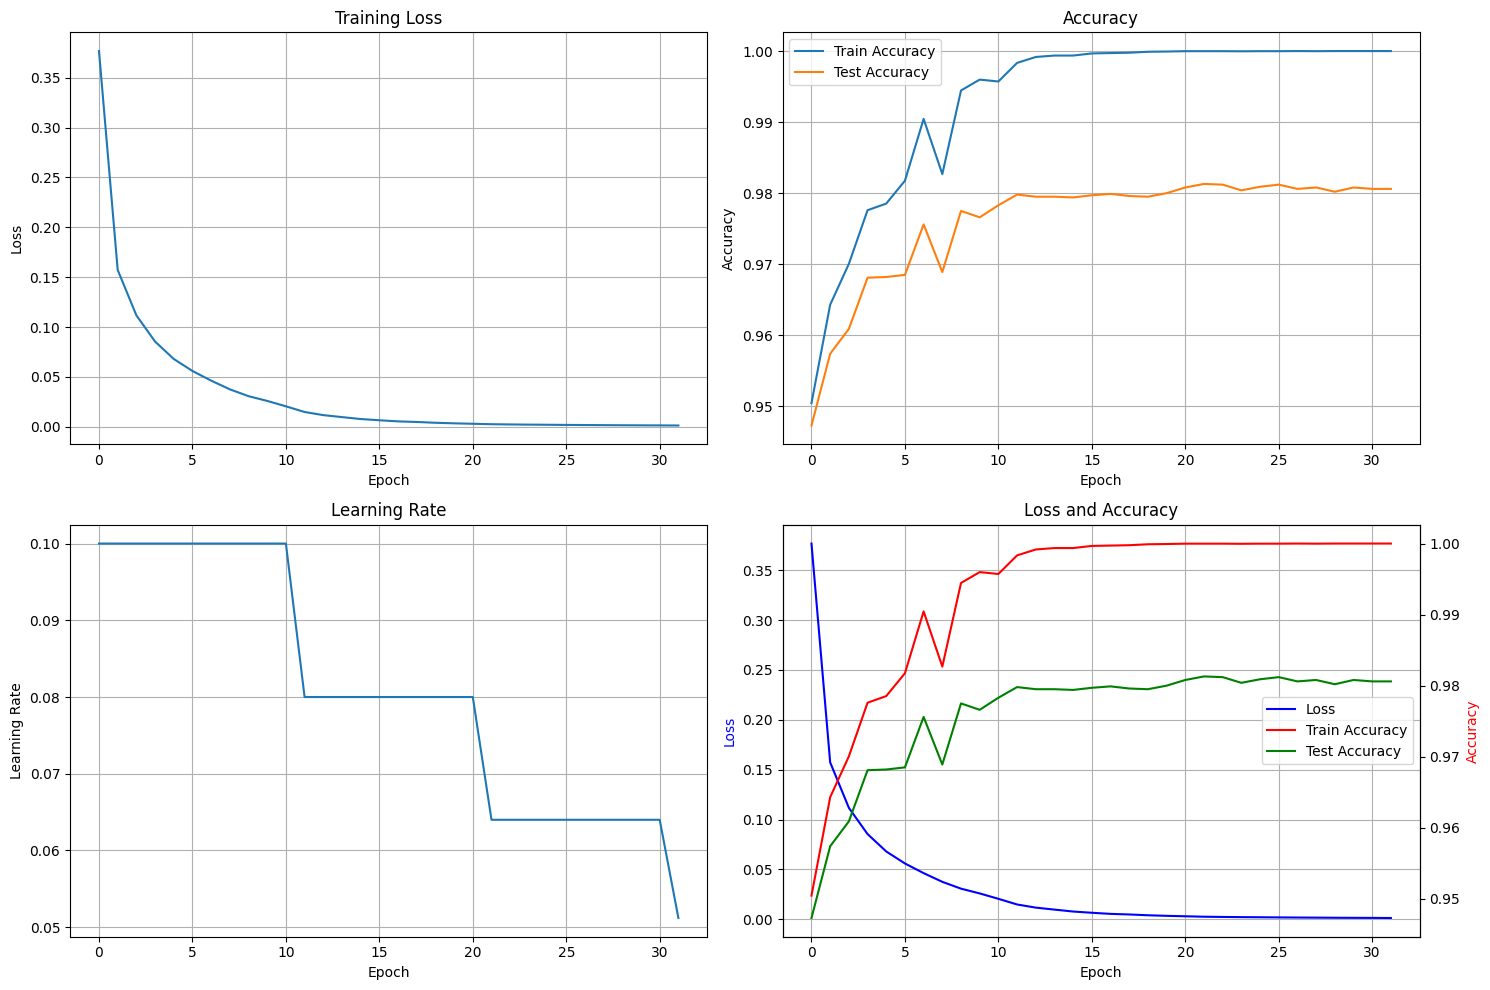


模型评估结果:
测试准确率: 0.9813

各类别准确率:
  数字 0: 0.9929 (979/986)
  数字 1: 0.9920 (1116/1125)
  数字 2: 0.9780 (977/999)
  数字 3: 0.9775 (997/1020)
  数字 4: 0.9723 (948/975)
  数字 5: 0.9823 (886/902)
  数字 6: 0.9919 (974/982)
  数字 7: 0.9770 (1018/1042)
  数字 8: 0.9795 (955/975)
  数字 9: 0.9688 (963/994)

混淆矩阵 (行: 真实标签, 列: 预测标签):
[[ 979    1    1    0    1    0    2    0    1    1]
 [   0 1116    2    1    1    1    1    1    2    0]
 [   5    2  977    2    3    0    1    4    3    2]
 [   2    1    4  997    0    5    0    4    6    1]
 [   0    0    5    0  948    1    3    2    0   16]
 [   2    1    0    2    2  886    5    0    1    3]
 [   3    0    0    0    1    0  974    0    4    0]
 [   2    4    5    0    3    0    0 1018    1    9]
 [   3    2    1    3    0    3    4    1  955    3]
 [   3    2    0    4    8    3    0    7    4  963]]


NameError: name 'visualize_predictions' is not defined

In [6]:
# 修改主函数以使用优化后的训练函数
# if __name__ == "__main__":
    # 加载数据
X_train, y_train, X_test, y_test, y_train_orig, y_test_orig = load_mnist_sklearn()

# 训练模型
model, X_test, y_test_orig = train_model(
    X_train, y_train, X_test, y_test, y_test_orig,
    layer_sizes=[784, 256, 128, 64, 10],
    learning_rate=0.1,
    epochs=50,
    batch_size=128,
    use_lr_decay=True,
    use_early_stopping=True,
    patience=10
)

# 评估模型
accuracy, confusion_matrix = evaluate_model(model, X_test, y_test, y_test_orig)

# 可视化一些预测结果
# visualize_predictions(model, X_test, y_test_orig)

# 保存模型
save_model(model, 'mnist_fc_model.npy')